## <center><u>Data Exploration and Wrangling For UBER ride sharing data</u></center>


<div class="alert alert-block alert-info">
   <h3>Description: </h3>
   
   Here we are working with the UBER ride sharing datset of Victoria, Australia. We will load the given datasets:
 <ul>
    <li> <b><i>dirty_data.csv : </i></b> We will try to do some EDA and find different types of errors (Syntactic/Semantic) </li>
    <li> <b><i>outliers.csv : </i></b> In this file we will just try to analyse and find outliers(if any) in all the dimensions </li>
    <li> <b><i>missing_value.csv : </i></b> In this file we will just try to find missing values(if any). </li>
    <li> <b><i>edges.csv : </i></b> This file we will use to find the journey distance between different nodes and travel time. </li>
    <li> <b><i>nodes.csv : </i></b> This file we will use along with <i>edges.csv</i> for finding journey distance and travel time . </li>
 </ul>

## Step 1: Import Libraries

In [1]:
# !pip install folium
import pandas as pd
import folium as fol
import warnings
warnings.filterwarnings('ignore')

## Step 2: Reading Data files

In [2]:
dirty_df = pd.read_csv("data/dirty_data.csv")
miss_df = pd.read_csv("data/missing_value.csv")
outlier_df = pd.read_csv("data/outliers.csv")
edges_df = pd.read_csv("data/edges.csv")
nodes_df = pd.read_csv("data/nodes.csv")


### 2.1 Understanding the  dirty data and the dimensions

In [3]:
dirty_df.head(5)

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID3501840116,1,8,1,-37.815834,145.046450,-37.800304,144.971834,7448.0,2018-02-01,01:17:26,2156.82,1:53:22,23.46
1,ID1393121718,0,5,7,-37.799614,144.932772,-37.861835,144.905716,12392.0,2018-06-22,14:09:42,3896.52,15:14:38,11.38
2,ID1314878251,0,6,3,-37.790797,144.985865,-37.811819,144.975182,2988.0,2018-07-06,08:23:47,852.78,8:37:59,2.82
3,ID1404486339,0,7,8,-37.861835,144.905716,-37.815834,145.046450,15150.2,2018-03-05,12:20:20,4911.60,13:42:11,14.80
4,ID5960060344,2,5,6,-37.809426,144.928865,-37.787442,144.980409,6687.7,2018-04-26,12:20:43,1728.36,12:49:31,136.46


In [4]:
dirty_df.describe()

,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,0.821429,4.732143,4.964286,-36.495029,144.933967,-36.499018,144.932610,15757.016071,4107.506571,81.731607
std,0.796658,2.564516,2.623059,10.039393,0.100735,10.038399,0.109074,16165.420364,3855.761494,167.726843
min,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,154.000000,38.460000,2.820000
25%,0.000000,3.000000,3.000000,-37.824031,144.926658,-37.824434,144.928854,5520.750000,1426.905000,12.577500
50%,1.000000,4.500000,5.000000,-37.814843,144.959720,-37.814036,144.957599,8596.500000,2555.070000,20.490000
75%,1.000000,7.000000,7.000000,-37.807044,144.985865,-37.805628,144.992234,13986.000000,4293.870000,56.722500
max,3.000000,9.000000,9.000000,37.861835,145.046450,37.816176,145.046450,51032.000000,13204.980000,857.050000


So, we have 280 records and there is no coverage errors.
<ul>
    <li> Minimum fare is 81.73 AUD and maximum fare is 857.05 AUD (thats a really huge amount for a trip)</li>
    <li> Journey Distance in meters is 154 meter as the minimum in records which is really a short distance for a trip.</li>
    <li> Origin and Destination latitude maximum value is positive which is strange as latitude of all points in Victoria should be negative. We need to look into this.</li>
    <li> Specification says Uber Type has 3 categories but we can observe its 0,1,2,3 in the data which is definitely not correct.</li>
    <li> We have got 9 regions based on the data from where the rides were taken.</li>
</ul>    

Also as per specification we need to add 2 extra dimensions which will tell us the day factor(i.e. weekday / weekend) and a time factor (i.e. morning, afternoon, night). These both dimensions can be derived from Departure Date and Departure Time respectively. So lets define a method for both, but will add these dimensions later once we validate Departure Date and Time's authenticity. 

In [5]:
# This method generates day factor based on Departure Date.
# WEEKDAY: 0
# WEEKEND: 1

def day_classifier(df):
    days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    day_class = {"Monday":0,"Tuesday":0,"Wednesday":0,"Thursday":0,"Friday":0,"Saturday":1,"Sunday":1}

    for i in range(0,len(df)):
        dt = df.loc[i,"Departure Date"].split("-")
        day = days[datetime(int(dt[0]),int(dt[1]),int(dt[2])).weekday()]
        df.loc[i,'day_factor'] = day_class[day]

In [6]:
# This method generates time factor based on Departure time.
# MORNING (i.e. 0) (6:00:00 - 11:59:59), 
# AFTERNOON (i.e. 1) (12:00:00 - 20:59:59), and
# NIGHT (i.e. 2) (21:00 - 5:59:59)

def time_classifier(df):
    for i in range(0, len(df)):
        if (datetime.strptime(str(df.loc[i]["Departure Time"]), FMT).hour >= 6) and (datetime.strptime(str(df.loc[i]["Departure Time"]), FMT).hour <= 11):
            df.loc[i,'time_factor'] = 0
        elif (datetime.strptime(str(df.loc[i]["Departure Time"]), FMT).hour >= 12) and (datetime.strptime(str(df.loc[i]["Departure Time"]), FMT).hour <= 20):
            df.loc[i,'time_factor'] = 1
        else:
            df.loc[i,'time_factor'] = 2

Now, lets try to see our different locations for the ride on the map and do other exploratory analysis to understand the data better and find out errors & inconsistencies (if any) .

## Step 3:  Exploratory Data Analysis on Dirty Data

Before beginning with EDA let us add an additional column "corrected" in our dataset which will keep a track if the record has been updated or corrected. It will act as a flag to keep a track which all records are been corrected while cleaning the dataset. 
<b> Corrected : 1 (it has been corrected) or 0 (not corrected or no error in that whole row) </b>

In [7]:
dirty_df["corrected"] = 0 # by default its 0

### 3.1: UBER Ride points across VIC (Origin Region)

The markers representing the points are varying in color based on their region alloted to them.
   <ul> 
    <li> Region 1 = "red" </li>
    <li> Region 2 = "lightgray" </li>
    <li> Region 3 = "blue" </li>
    <li> Region 4 = "green" </li>
    <li> Region 5 = "orange" </li>
    <li> Region 6 = "black" </li>
    <li> Region 7 = "darkpurple" </li>
    <li> Region 8 = "beige" </li>
    <li> Region 9 = "pink" </li>
   </ul> 

In [8]:
# CREATING AN EMPTY MAP
o_map = fol.Map(location=[-38, 144], tiles="Mapbox Bright", zoom_start=8)

# METHOD DEFINES THE COLOR FOR THE MARKER BASED ON REGION
def color_icon(region):
    if region == 1:
        color = "red"
    elif region ==2:
        color = "lightgray"
    elif region ==3:
        color = "blue"
    elif region ==4:
        color = "green"
    elif region ==5:
        color = "orange"
    elif region ==6:
        color = "black"
    elif region ==7:
        color = "darkpurple"
    elif region ==8:
        color = "beige"
    else:
        color = "pink"
    return color

# ADDING MARKERS ON THE MAP
for i in range(0,len(dirty_df)):
    o_map.add_child(fol.Marker([dirty_df.loc[i]['Origin Latitude'],dirty_df.loc[i]['Origin Longitude']],popup=dirty_df['Unnamed: 0'][i], icon= fol.Icon(icon = "home", color=color_icon(dirty_df.loc[i]['Origin Region']))))

o_map


### 3.2: UBER Ride points across VIC (Destination Region)

In [9]:
# CREATING AN EMPTY MAP
d_map = fol.Map(location=[-38, 144], tiles="Mapbox Bright", zoom_start=8)

# ADDING MARKERS ON THE MAP
for i in range(0,len(dirty_df)):
    d_map.add_child(fol.Marker([dirty_df.loc[i]['Destination Latitude'],dirty_df.loc[i]['Destination Longitude']],popup=dirty_df['Unnamed: 0'][i],icon= fol.Icon(icon = "flag",color=color_icon(dirty_df.loc[i]['Destination Region']))))

d_map

As we can see, based on the origin and destination points of rides on the map shows few coordinates are outside VIC infact outside Australia. So we need to fix the latitude as we also saw that there are positive latitudes which should not be the case if points belongs in VIC.

<div class="alert alert-block alert-warning">
    <h3><u> Error 1, 2 Outliers for origin/ destination latitude (Semantic Error) : </u></h3> 
    <p> As we know the points are only based in VIC, so any point outside that is an outlier to the dataset and it's semantically incorrect for our dataset.</p>
    <h3><u> Fix: </u></h3>
    <p> The best possible fix would be changing those negative latitudes to positive then they will be in VIC, as its a high chance that it could be caused due to data entry error.</p>

In [10]:
# correcting the incorrect lat long for origin and destination
# setting the corrected flag for the rows which are being corrected
dirty_df.loc[dirty_df["Origin Latitude"] > 0, "corrected"] = 1
dirty_df.loc[dirty_df["Destination Latitude"] > 0, "corrected"] = 1

dirty_df.loc[dirty_df["Origin Latitude"] > 0, "Origin Latitude"] = -dirty_df.loc[dirty_df["Origin Latitude"] > 0, "Origin Latitude"]
dirty_df.loc[dirty_df["Destination Latitude"] > 0, "Destination Latitude"] = -dirty_df.loc[dirty_df["Destination Latitude"] > 0, "Destination Latitude"]

### 3.3 Check Date & Time format
Let's check for the format of date and time, so that it should be consistent when we do some analysis.

In [11]:
# IMPORTING DATETIME LIBRARIES
from datetime import datetime
from datetime import timedelta

id_list = []
date_list =[]

# CHECKING THE FORMAT OF DATE
for i in range(0,len(dirty_df)):
    try:
        datetime.strptime(dirty_df.loc[i]['Departure Date'], '%Y-%m-%d')
    except ValueError:
        # print('ID: ' + dirty_df.loc[i]['Unnamed: 0'] + ' Invalid date: {}'.format(dirty_df.loc[i]['Departure Date']))
        id_list.append(dirty_df.loc[i]['Unnamed: 0'])
        date_list.append(dirty_df.loc[i]['Departure Date'])
        
d ={}
for i in range(0,len(id_list)):
    d[id_list[i]] = date_list[i]

invalid_date = pd.Series(d).to_frame().reset_index()
invalid_date.columns = ["id","date"]
invalid_date.head(5)

,id,date
0,ID1959463567,2018-18-05
1,ID3198565330,2018-17-03
2,ID1328595966,2018-16-05
3,ID3130522574,2018-23-06
4,ID3230556880,2018-26-02


As we can see there are few dates not in the right format either their month and day are swapped or date is exceeding the range of the month.

Let's check time format as well.

In [12]:
# IMPORTING re TO CHECK THE CONSITENCIES OF TIME
import re

id2_list = []
time_list =[]


for i in range(0,len(dirty_df)):
    dept_flag = re.match("^(0+[0-9]|1[0-9]|2[0-3])[\:]([0-5][0-9])[\:]([0-5][0-9])$",dirty_df.loc[i]['Departure Time'])
    arr_flag = re.match("^(0+[0-9]|1[0-9]|2[0-3])[\:]([0-5][0-9])[\:]([0-5][0-9])$",dirty_df.loc[i]['Arrival Time'])
    if not dept_flag:
        id2_list.append(dirty_df.loc[i]['Unnamed: 0'])
        time_list.append([dirty_df.loc[i]['Departure Time'],"Departure Time"])
        #print('ID: ' + dirty_df.loc[i]['Unnamed: 0'] + ' Invalid date: {}'.format(dirty_df.loc[i]['Departure Time']))  
    
    if not arr_flag:
        id2_list.append(dirty_df.loc[i]['Unnamed: 0'])
        time_list.append([dirty_df.loc[i]['Arrival Time'],"Arrival Time"])
        #print('ID: ' + dirty_df.loc[i]['Unnamed: 0'] + ' Invalid date: {}'.format(dirty_df.loc[i]['Arrival Time'])) 

time = {}

for i in range(0,len(id2_list)):
    time[id2_list[i]] = time_list[i]

invalid_time = pd.DataFrame.from_dict(time).transpose()
invalid_time.reset_index(inplace=True)
invalid_time.columns = ["id","time","type"]
invalid_time.head(5)

,id,time,type
0,ID3501840116,1:53:22,Arrival Time
1,ID1314878251,8:37:59,Arrival Time
2,ID1804119838,0:40:21,Arrival Time
3,ID1447619795,7:37:30,Arrival Time
4,ID3116900903,4:46:32,Arrival Time


So, there are some time values which are inconsistent and not following the format like 00:00:00. We need to fix these inconsitencies as well before we move ahead.

<div class="alert alert-block alert-warning">
<h3><u> Error 3, 4 Departure Date - month and date swapped, date exceeding the month (Syntactic Error) : </u></h3> 
    <p> The date does not follow the consistent format. At some places the month and date are swapped like 2018-18-06 should be 2018-06-18 and another error is date exceeding the month like 201-06-31 which should be 2018-06-30 as June does not have 31 days.</p>
    <h3><u> Fix: </u></h3>
    <ul>
        <li> <b> For month and date swapped: Swap them </b> </li>
        <li> <b> For date exceeding month: Reduce the day to the last day of that month. </b> </li>
    </ul>

In [13]:
# METHOD TO FIX THE DATE WHICH EXCEEDS THE MONTH
def fix_date(year, month, day):
    # Calculate the last date of the given month
    nextmonth = datetime(year, month, 1) + timedelta(days=35)
    lastday = nextmonth.replace(day=1) - timedelta(days=1)

    if len(str(month)) == 1:
        return (str(year) + "-0" + str(month) + "-" + str(min(day, lastday.day)))
    else:
        return (str(year) + "-" + str(month) + "-" + str(min(day, lastday.day)))


# CORRECTING THE MONTH AND DAY SWAPPED (IN invalid_date)
invalid_date["corr_date"] = invalid_date["date"]

for i in range(0, len(invalid_date)):
    dt = invalid_date.loc[i]["corr_date"].split("-")
    
    if int(dt[1]) > 12:
        tmp = dt[2]
        dt[2] = dt[1]
        dt[1] = tmp
        invalid_date.loc[i]["corr_date"] = dt[0]+"-" + dt[1] + "-" + dt[2]
    else:
        str_dt = fix_date(datetime(int(dt[0]),1,1).year, datetime(2000,int(dt[1]),1).month, datetime(2000,1,int(dt[2])).day)
        invalid_date.loc[i]["corr_date"] = str_dt

# FIXING THE dirty_df FOR DATES
for i in range(0,len(invalid_date)):
    dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_date.loc[i]["id"],"Departure Date"] = invalid_date.loc[i]["corr_date"]
    dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_date.loc[i]["id"],"corrected"] = 1 

Since now the Departure date has been fixed for the format we can add the day factor in our dataset which is like 0 for weekdays and 1 for weekends.

In [14]:
day_classifier(dirty_df)

<div class="alert alert-block alert-warning">
    <h3><u> Inconsistency 1, 2 Inconsistent Arrival / Departure Time : </u></h3> 
    <p> The time does not follow the consistent format.</p>
    <h3><u> Fix: </u></h3>
    <p> Just need to correct the format to make it consistent. We will just change its type to datetime.time so that format becomes consistent. And for this we will not update our corrected flag, as its just an inconsistency and not an error. </p>

In [15]:
dirty_df["Arrival Time"] = pd.to_datetime(dirty_df['Arrival Time'],format= '%H:%M:%S' ).dt.time
dirty_df["Departure Time"] = pd.to_datetime(dirty_df['Departure Time'],format= '%H:%M:%S' ).dt.time

### 3.4 Correlation between dimensions
Let's see some correlation between dimensions to understand the linear relationship

In [16]:
import matplotlib.pyplot as plt

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = dirty_df.select_dtypes(include=numerics)

plt.matshow(newdf.corr())
plt.xticks(range(len(newdf.columns)), newdf.columns, rotation="vertical")
plt.yticks(range(len(newdf.columns)), newdf.columns)
plt.colorbar()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 25
plt.rcParams["figure.figsize"] = fig_size
plt.show()

<Figure size 480x480 with 2 Axes>

From the correlation plot above we can see that: 
<ul>
   <li>Fare$ has a strong relation with Uber type, Journey Distance(m) and Travel Time(s). </li>
   <li>Origin / Destination Region has a strong relation with Journey Distance & Travel Time(s). </li>
</ul>

###  3.5: Understanding different Uber Type and Fare relation
Let's see different UBER types and their counts in our dataset. We already know that there is one extra category based on the description we saw. So we need to find that odd one out.

In [17]:
dirty_df.groupby(["Uber Type"])["Uber Type"].count()
dirty_df.loc[(dirty_df["Uber Type"] == 3) | (dirty_df["Uber Type"] == 2)]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,corrected,day_factor
4,ID5960060344,2,5,6,-37.809426,144.928865,-37.787442,144.980409,6687.7,2018-04-26,12:20:43,1728.36,12:49:31,136.46,0,0.0
7,ID5261176554,2,1,7,-37.811664,144.965229,-37.861835,144.905716,8478.0,2018-07-15,19:26:16,2926.74,20:15:02,224.60,0,1.0
8,ID5670774661,2,8,1,-37.815834,145.046450,-37.813893,144.959240,8062.0,2018-04-23,16:43:20,2325.78,17:22:05,176.02,0,0.0
20,ID5851533409,2,2,2,-37.815834,145.046450,-37.812841,144.939897,9719.0,2018-07-10,20:39:32,2757.00,21:25:29,204.54,0,0.0
22,ID5886275296,2,3,3,-37.815834,145.046450,-37.816977,144.976883,6881.0,2018-01-06,21:22:45,2006.64,21:56:11,169.99,0,1.0
27,ID5541874337,2,1,3,-37.811416,144.973073,-37.817346,145.005497,3351.0,2018-01-04,05:22:25,821.16,05:36:06,84.90,0,0.0
28,ID5897208891,2,5,9,-37.809278,144.929146,-38.110916,144.654173,43421.0,2018-07-24,11:37:16,10400.70,14:30:36,705.08,0,0.0
39,ID5938668944,2,8,4,-37.807202,145.026637,-37.805676,144.931867,9131.0,2018-02-04,09:23:28,2353.98,10:02:41,177.18,0,1.0
40,ID5479788637,2,9,2,-38.110916,144.654173,-37.804583,144.935393,43482.0,2018-02-23,00:39:26,10415.64,03:33:01,723.94,0,0.0
48,ID5111529081,2,4,8,-37.802871,145.016633,-37.815834,145.046450,5851.0,2018-03-16,19:15:14,1772.16,19:44:46,139.15,0,0.0


In [18]:
dirty_df.groupby(["Uber Type"])["Fare$"].mean()

Uber Type
0     14.365948
1     27.985400
2    296.305806
3     24.450000
Name: Fare$, dtype: float64

In [19]:
dirty_df.groupby(["Uber Type"])["Fare$"].describe()

,count,mean,std,min,25%,50%,75%,max
Uber Type,,,,,,,,
0,116.0,14.365948,6.111474,2.82,9.8275,12.850,17.995,29.81
1,100.0,27.985400,17.570685,6.43,14.7475,22.665,29.685,75.55
2,62.0,296.305806,260.439693,11.52,109.6100,218.735,302.975,857.05
3,2.0,24.450000,5.586144,20.50,22.4750,24.450,26.425,28.40


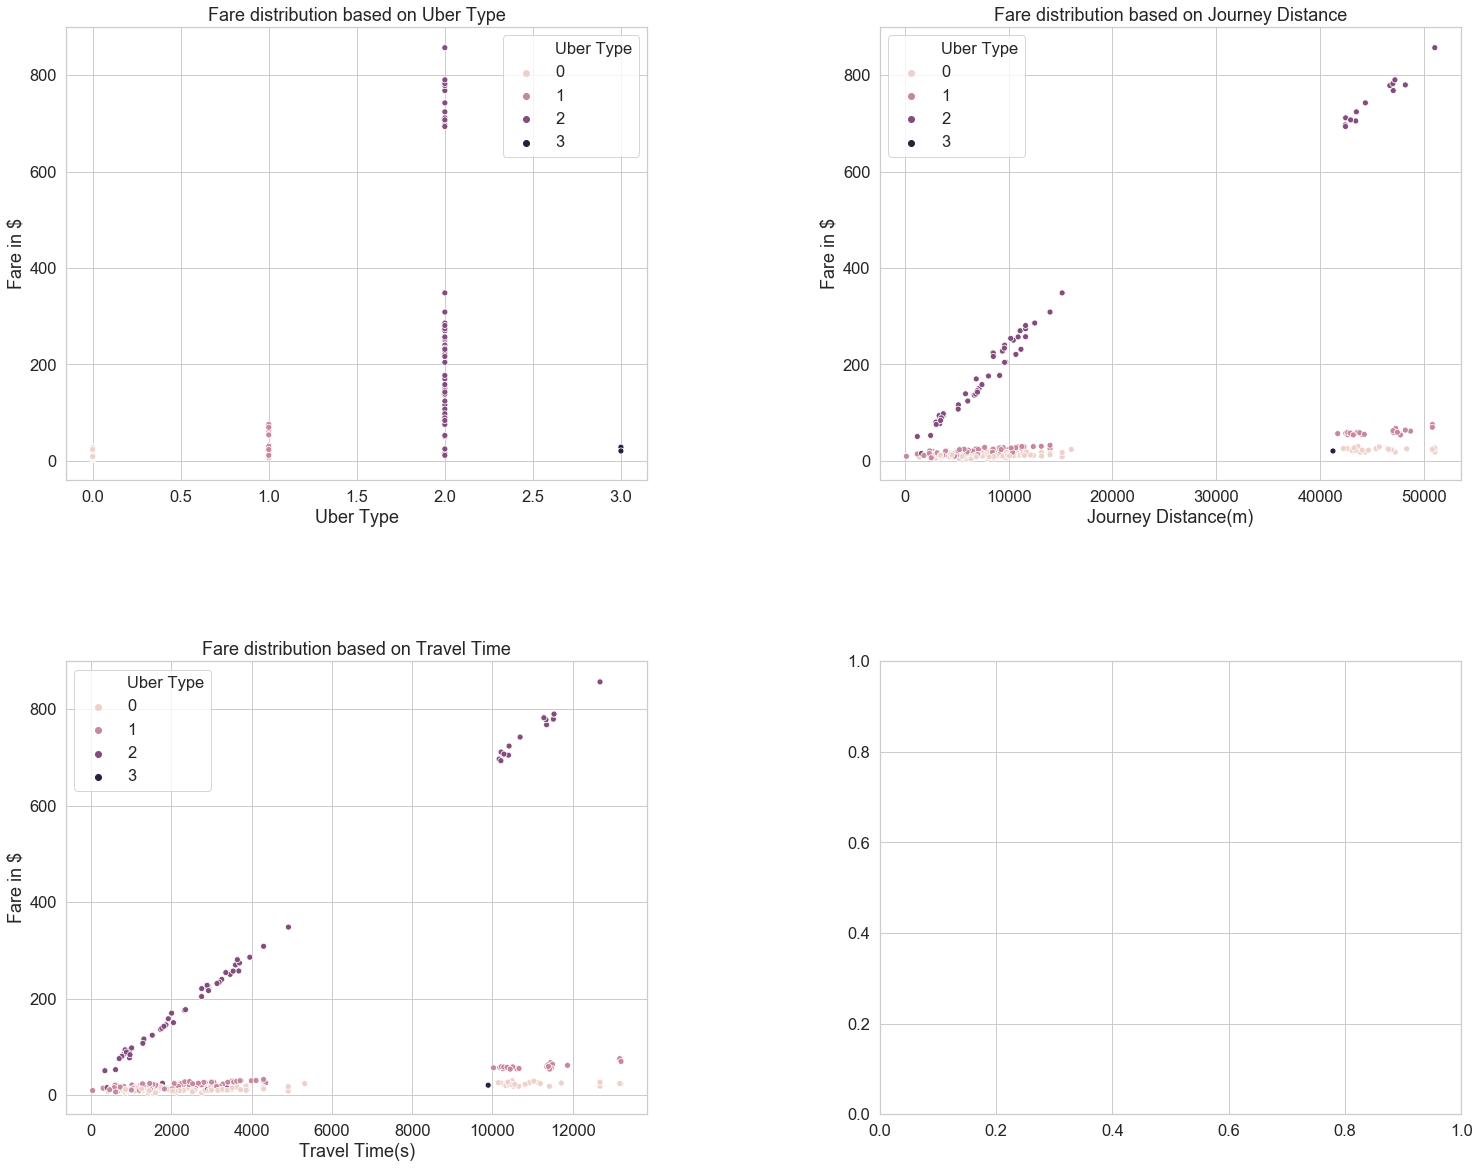

In [20]:
import seaborn as sb
# SETTING STYLE FOR seaborn PLOT
sb.set(font_scale=1.5)
sb.set_style('whitegrid')

# CONFIGURING seaborn (sb) WITH THE DATA AND AXES VALUES 
f, ax = plt.subplots(figsize=(25,20),ncols=2, nrows=2)
f.subplots_adjust(wspace=0.4, hspace=0.4)

a=sb.scatterplot(ax = ax[0][0], x= dirty_df['Uber Type'], y='Fare$', hue=dirty_df['Uber Type'],  data=dirty_df)
b=sb.scatterplot(ax = ax[0][1], x= dirty_df['Journey Distance(m)'], y='Fare$', hue=dirty_df['Uber Type'],  data=dirty_df)
c=sb.scatterplot(ax = ax[1][0], x= dirty_df['Travel Time(s)'], y='Fare$', hue=dirty_df['Uber Type'],  data=dirty_df)

# PLOTTING THE FIGURE
a.set_ylabel('Fare in $')
b.set_ylabel('Fare in $')
c.set_ylabel('Fare in $')

ax[0][0].set_title("Fare distribution based on Uber Type")
ax[0][1].set_title("Fare distribution based on Journey Distance")
ax[1][0].set_title("Fare distribution based on Travel Time")

plt.show()
plt.clf()
plt.close()

By viewing these scatter plots, we can see the two records of UBER type 3 are coinciding with UBER type 0. This tells us that it could be a wrong entry for those two records and ideally they should be 0. But let's try to verify it with the help of transaction ID (Unnamed: 0) as it follows a pattern and its third character is same for all the same UBER Type. 

In [21]:
# TRYING TO IDENTIFY THE PATTERN OF ID AND UBER TYPE
dirty_df.loc[dirty_df["Uber Type"] == 0]["Unnamed: 0"]
dirty_df.loc[dirty_df["Uber Type"] == 1]["Unnamed: 0"] 
dirty_df.loc[dirty_df["Uber Type"] == 2]["Unnamed: 0"] 
dirty_df.loc[dirty_df["Uber Type"] == 3]["Unnamed: 0"] 


126    ID3362055374
129    ID1208828616
Name: Unnamed: 0, dtype: object

<ul>
    <li><b>Uber Type 0:</b> 1 </li>
    <li><b>Uber Type 1:</b> 3, </li>
    <li><b>Uber Type 2:</b> 5, </li>
    <li><b>Uber Type 3:</b> 1,3 (Only 2 records and also we know that only 3 categories of UBER type exists in the data. So this must be changed) </li>
</ul>
Let's try to observe the pattern visually and more carefully.

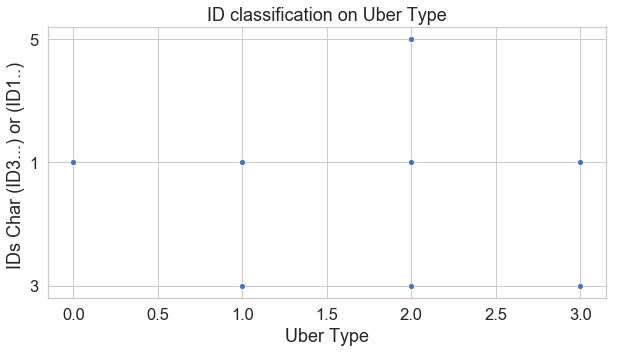

In [22]:
# SETTING STYLE FOR seaborn PLOT
sb.set(font_scale=1.5)
sb.set_style('whitegrid')

# CONFIGURING seaborn (sb) WITH THE DATA AND AXES VALUES 
plt.subplots(figsize=(10,5))

a=sb.scatterplot(x=dirty_df['Uber Type'], y=dirty_df["Unnamed: 0"].str.extract(r'^ID(\d{1})', expand=False), data=dirty_df)

# PLOTTING THE FIGURE
a.set_ylabel('IDs Char (ID3...) or (ID1..) ')

plt.title("ID classification on Uber Type")

plt.show()
plt.clf()
plt.close()

As we observed that, there is a pattern in 'Unnamed: 0' or ID column for different UBER types, like for type 0: ID1... and for type 1: ID3... and so on.
Also in the 'ID classification on UBER type' scatter plot we get to see that for type 1 and type 2 there are few IDs with slight verification.

<ul>
    <li><b>Uber Type 0:</b> '1' </li>
    <li><b>Uber Type 1:</b> '3', '1' ('1' is hardly for two or three records, which are not following the trend which means this is an error wherever there is '1' for this type)</li> 
    <li><b>Uber Type 2:</b> '5', '3', '1' ('3' and '1' are hardly for two or three records, which are not following the trend which means this is an error wherever there is '3' and '1' for this type)</li>
    <li><b>Uber Type 3:</b> 1,3 (Only 2 records and also we know that only 3 categories of UBER type exists in the data. So this must be changed) </li>
</ul>

In [23]:
uber_type = {'0':[],'1':[],'2':[]}

for i in range(len(dirty_df)):
    if (dirty_df['Uber Type'][i]==0) & (dirty_df['Unnamed: 0'][i][2]!='1'):
        uber_type['0'].append(dirty_df.loc[i]["Unnamed: 0"]) 
        #print(dirty_df.loc[i]["Unnamed: 0"], dirty_df.loc[i]["Uber Type"])
    elif (dirty_df['Uber Type'][i]==1) & (dirty_df['Unnamed: 0'][i][2]!='3'):
        uber_type['1'].append(dirty_df.loc[i]["Unnamed: 0"]) 
        #print(dirty_df.loc[i])
    elif (dirty_df['Uber Type'][i]==2) & (dirty_df['Unnamed: 0'][i][2]!='5'):
        uber_type['2'].append(dirty_df.loc[i]["Unnamed: 0"]) 
        #print(dirty_df.loc[i])
uber_type

{'0': [],
 '1': ['ID1885469348', 'ID1574949198'],
 '2': ['ID1701214714', 'ID1854884366', 'ID3988603151', 'ID1248152001']}

<ul>
    <li><b>For UBER type 1:</b> 'ID1885469348', 'ID1574949198' does not follow the trend.</li>
    <li><b>For UBER type 2:</b> 'ID1701214714', 'ID1854884366', 'ID3988603151', 'ID1248152001' does not follow the trend.</li>
</ul>

<div class="alert alert-block alert-warning">
    <h3><u> Error 5 --> Additional UBER Type (i.e. type 3) (Syntactic Error) : </u></h3> 
    <p> There are only 3 UBER types as per specification in the dataset which are 0,1,2. As type 3 has only 2 records which probably is a result of data entry error and follows the trend similar to type 0 and type 1.</p>
    <h3><u> Fix: </u></h3>
    <p> Based on the pattern observed with the fare and IDs, we have 2 records in type 3 where one falls in type 0 and another one in type 1. So we will change the UBER type for these 2 records to type 0 and type 1 respectively</p>

In [24]:
utype = dirty_df.loc[dirty_df["Uber Type"] == 3]
for i in range (0, len(utype)):
    if utype.iloc[i]["Unnamed: 0"][2] == '1' :   # type 0
        dirty_df.loc[dirty_df["Unnamed: 0"] == utype.iloc[i]["Unnamed: 0"],"Uber Type"] = 0
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == utype.iloc[i]["Unnamed: 0"],"corrected"] = 1
    
    elif utype.iloc[i]["Unnamed: 0"][2] == '3' : # type 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == utype.iloc[i]["Unnamed: 0"],"Uber Type"] = 1
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == utype.iloc[i]["Unnamed: 0"],"corrected"] = 1
    
    else:                                        # type 2
        dirty_df.loc[dirty_df["Unnamed: 0"] == utype.iloc[i]["Unnamed: 0"],"Uber Type"] = 2
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == utype.iloc[i]["Unnamed: 0"],"corrected"] = 1

dirty_df.loc[dirty_df["Uber Type"] == 3]

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$,corrected,day_factor


<div class="alert alert-block alert-warning">
    <h3><u> Error 6 --> UBER Type 1,2 (Semantic Error) : </u></h3> 
    <p> The type 1 and type 2 has got two to four IDs which does not follow the pattern of their ID 'ID3...' and 'ID5...' respectively. So the values does not maintain the semantics.</p>
    <h3><u> Fix: </u></h3>
    <p> The best possible fix we can do, is to change the UBER type for these 2 to 4 records to the types where they follow the pattern of IDs. But this fix will definitely create outliers in our scatter plot with fare as we have seen above because even though for these 2 to 4 records they don't follow the ID trend but they follow the trend with Fare, Journey Distance etc.</p>

In [25]:
for i in range(0,len(uber_type['1'])):
    if uber_type['1'][i][2] == '1':
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"Uber Type"] = 0
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"corrected"] = 1
        
    elif uber_type['1'][i][2] == '3':
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"Uber Type"] = 1
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"corrected"] = 1
        
    elif uber_type['1'][i][2] == '5':
        print(dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"Uber Type"])
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"Uber Type"] = 2
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['1'][i],"corrected"] = 1

for i in range(0,len(uber_type['2'])):
    if uber_type['2'][i][2] == '1':
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"Uber Type"] = 0
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"corrected"] = 1
        
    elif uber_type['2'][i][2] == '3':
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"Uber Type"] = 1
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"corrected"] = 1
        
    elif uber_type['2'][i][2] == '5':
        print(dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"Uber Type"])
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"Uber Type"] = 2
        # marking the corrected flag as 1
        dirty_df.loc[dirty_df["Unnamed: 0"] == uber_type['2'][i],"corrected"] = 1
        

### 3.6 Validating Regions alloted 

As we have seen while plotting a map for origin points and destination points on the map, quite a few points were falling in another region's cluster and marked with some other region. So we need to fix those regions or rather try to predict the closest possible region for the point which seems like an outlier on the map.

We will use our outlier.csv and missing_value.csv to train our model for prediction and then dirty data will be used for testing and getting the final predictions for regions.

In [26]:
# FINDING THE EUCLIDEAN DISTANCE BETWEEN ANY 2 POINTS
import math

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    
    radius = 6378 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

In [27]:
miss1 = pd.DataFrame([miss_df['Origin Region'],miss_df['Origin Latitude'],miss_df['Origin Longitude']]).transpose()
miss1.columns = ['Region','Latitude','Longitude']
miss2 = pd.DataFrame([miss_df['Destination Region'],miss_df['Destination Latitude'],miss_df['Destination Longitude']]).transpose()
miss2.columns = ['Region','Latitude','Longitude']

out1 = pd.DataFrame([outlier_df['Origin Region'],outlier_df['Origin Latitude'],outlier_df['Origin Longitude']]).transpose()
out1.columns = ['Region','Latitude','Longitude']
out2 = pd.DataFrame([outlier_df['Destination Region'],outlier_df['Destination Latitude'],outlier_df['Destination Longitude']]).transpose()
out2.columns = ['Region','Latitude','Longitude']

dirty1 = pd.DataFrame([dirty_df['Origin Region'],dirty_df['Origin Latitude'],dirty_df['Origin Longitude']]).transpose()
dirty1.columns = ['Region','Latitude','Longitude']
dirty2 = pd.DataFrame([dirty_df['Destination Region'],dirty_df['Destination Latitude'],dirty_df['Destination Longitude']]).transpose()
dirty2.columns = ['Region','Latitude','Longitude']

alldata_reg = miss1.append([miss2,out1,out2,dirty1,dirty2])
alldata_reg.drop_duplicates(inplace=True)
alldata_reg.reset_index(inplace=True, drop = True)
alldata_reg["dist_center(km)"] = 0
alldata_reg["predicted_region"] = -1

region_center = alldata_reg.groupby('Region').agg('mean')
region_center.reset_index(inplace=True)
#region_center


In [28]:
for i in range(0,len(alldata_reg)):
    origin = [alldata_reg.loc[i,"Latitude"], alldata_reg.loc[i,"Longitude"]]
    destination = [region_center.loc[region_center["Region"] == alldata_reg.loc[i]["Region"]]["Latitude"], region_center.loc[region_center["Region"] == alldata_reg.loc[i]["Region"]]["Longitude"]]
    alldata_reg.loc[i, "dist_center(km)"] = distance(origin,destination)
    
    predict_dict = {} 
    if alldata_reg["dist_center(km)"][i] > 2:
        # check distance with other centers
        for k in range(0, len(region_center)):
            dist = distance(origin, [region_center.loc[k,"Latitude"], region_center.loc[k,"Longitude"]])
            predict_dict[region_center.loc[k,"Region"]] = dist
        
        mini = min(val for val in predict_dict.values())
        alldata_reg.loc[i,"predicted_region"] = float(str([key for key,v in predict_dict.items() if v == mini][0]))
    else:
        alldata_reg.loc[i,"predicted_region"] = alldata_reg["Region"][i]


In [29]:
invalid_loc = alldata_reg.loc[alldata_reg["Region"] != alldata_reg["predicted_region"]]
invalid_loc.reset_index(inplace=True)
invalid_loc

,index,Region,Latitude,Longitude,dist_center(km),predicted_region
0,29,3.0,-37.819703,145.010013,2.093026,4.0
1,170,1.0,-37.803153,144.936730,2.011528,5.0
2,228,2.0,-37.815834,145.046450,9.267136,8.0
3,229,7.0,-37.773803,144.983647,7.613746,6.0
4,230,3.0,-37.815834,145.046450,5.293421,8.0
5,238,6.0,-37.820082,144.968573,3.827233,1.0
6,400,3.0,-37.800768,144.970004,2.391001,1.0
7,402,4.0,-38.110916,144.654173,45.244006,9.0
8,403,4.0,-37.805676,144.931867,5.986392,5.0


<div class="alert alert-block alert-warning">
    <h3><u> Error 7 --> Wrong Region Allocation for few points (Coverage Error) : </u></h3> 
    <p> The region has been alloted wrong for some points though visually they seem to belong in some another regions's cluster but they have another region as the label. (For Eg. a point belongs in region 1 but has been marked as region 2)</p>
    <h3><u> Fix: </u></h3>
    <p> The best possible fix we can do, is to take mean of lat and long for each region which will become our center for the region and as observed mostly distance from center point is 2 kms so we can consider 2 kms as the radius for each region. After that we can find which are the points which are exceeding the 2kms limit away from the center for their given region and then we can predict the region for those points based on their proximity with other region's center points whichever region's center distance is less comparatively we will allocate that region to the point.</p>

In [30]:
for i in range(0, len(invalid_loc)):
    dirty_df.loc[(dirty_df['Origin Region'] != invalid_loc.loc[i, 'predicted_region']) & (dirty_df["Origin Latitude"] == invalid_loc["Latitude"][i]) & (dirty_df["Origin Longitude"] == invalid_loc["Longitude"][i]), "corrected"] = 1 
    dirty_df.loc[(dirty_df['Destination Region'] != invalid_loc.loc[i, 'predicted_region']) & (dirty_df["Destination Latitude"] == invalid_loc["Latitude"][i]) & (dirty_df["Destination Longitude"] == invalid_loc["Longitude"][i]), "corrected"] = 1
        
    dirty_df.loc[(dirty_df['Origin Region'] != invalid_loc.loc[i, 'predicted_region']) & (dirty_df["Origin Latitude"] == invalid_loc["Latitude"][i]) & (dirty_df["Origin Longitude"] == invalid_loc["Longitude"][i]), "Origin Region"] = invalid_loc.loc[i, "predicted_region"]
    dirty_df.loc[(dirty_df['Destination Region'] != invalid_loc.loc[i, 'predicted_region']) & (dirty_df["Destination Latitude"] == invalid_loc["Latitude"][i]) & (dirty_df["Destination Longitude"] == invalid_loc["Longitude"][i]), "Destination Region"] = invalid_loc.loc[i, "predicted_region"]
    

In [31]:
# Make an empty map
m = fol.Map(location=[-38, 145], tiles="Mapbox Bright", zoom_start=8)

# I can add marker one by one on the map
for i in range(0,len(dirty_df)):
    m.add_child(fol.Marker([dirty_df.loc[i]['Origin Latitude'],dirty_df.loc[i]['Origin Longitude']],popup="Predict:" + str(dirty_df['Origin Region'][i]) + "\nLat:" + str(dirty_df['Origin Latitude'][i]) + "\nLong:" + str(dirty_df['Origin Longitude'][i]) ,icon= fol.Icon(icon = "flag",color=color_icon(int(dirty_df.loc[i]['Origin Region'])))))
    
m   

### 3.7 Validating Journey Distance(m) (Is it really the shortest path?) 

Here we will try to validate whether the journey distance given in the dataset is actually the shortest distance for any ride or not, as it could be wrong due to some data entry issues. So it would be better if we verify before moving ahead. We will use Dijkstra algorithm to find the shortest journey distance between the source point and the destination point and then compare it with the given journey distance in the dataset.

In [32]:
# importing networkx package for applying Dijkstra algorithm
import networkx as netx

# creating graph using edges and nodes in the edges.csv and nodes.csv respectively
graph = netx.from_pandas_edgelist(edges_df,'u','v',['distance(m)'])

id3_list = []
dist_list = []

for i in range(0,len(dirty_df)):
    # computing shortest distance for all nodes in dirty data
    distance, path = netx.single_source_dijkstra(graph, source = int(nodes_df['Unnamed: 0'][(nodes_df['lat'] == dirty_df.iloc[i]['Origin Latitude']) & (nodes_df['lon'] == dirty_df.iloc[i]['Origin Longitude'])]), target = int(nodes_df['Unnamed: 0'][(nodes_df['lat'] == dirty_df.iloc[i]['Destination Latitude']) & (nodes_df['lon'] == dirty_df.iloc[i]['Destination Longitude'])]), weight='distance(m)')
   
    # checking if distance from dirty data and shortest distance from dijkstra are not equal
    if distance != round(dirty_df.iloc[i]['Journey Distance(m)']):
        id3_list.append(dirty_df.iloc[i]["Unnamed: 0"])   
        dist_list.append([round(dirty_df.iloc[i]["Journey Distance(m)"]), distance])

dist = {}

for i in range(0,len(id3_list)):
    dist[id3_list[i]] = dist_list[i]

invalid_dist = pd.DataFrame.from_dict(dist).transpose()
invalid_dist.reset_index(inplace=True)
invalid_dist.columns = ["id","given_distance","computed_distance"]
invalid_dist


,id,given_distance,computed_distance
0,ID1404486339,15150.0,15151.0
1,ID5960060344,6688.0,6689.0
2,ID3428249873,43592.0,43586.0
3,ID3780031863,9079.0,9080.0
4,ID1804119838,9174.0,9165.0


<div class="alert alert-block alert-warning">
    <h3><u> Error 8 --> Wrong Journey Distance(m) (Semantic Error) : </u></h3> 
    <p> The distance is not the shortest distance in few cases and in some cases its completely wrong.</p>
    <h3><u> Fix: </u></h3>
    <p> The best possible fix we can do, is to replace those wrong distance values by the computed distance values calculated by using Dijkstra algorithm.</p>

In [33]:
# fixing the wrong distance with the correct value
for i in range(0, len(invalid_dist)):
    dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_dist.loc[i,"id"], "Journey Distance(m)"] = invalid_dist.loc[i,"computed_distance"]
    dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_dist.loc[i,"id"], "corrected"] = 1


### 3.8 Validating Travel time based on the shortest distance

In [34]:
# calculates the travel time based on the edges for a path
def traveltime(path, edges):
    tt = 0
    for i in range(len(path)-1):
        # print(edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['distance(m)'].values, edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['speed(km/h)'].values)
        tt = tt + (edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['distance(m)'].values[0] * 1.0 * 3600) / (edges[((edges.u==path[i]) & (edges.v== path[i+1])) | ((edges.v==path[i]) & (edges.u== path[i+1]))]['speed(km/h)'].values[0] * 1000)

    return tt

def time_diff(at,dt):
    FMT = '%H:%M:%S'
    at = str(at)
    dt = str(dt)
    tdelta = datetime.strptime(at, FMT) - datetime.strptime(dt, FMT)
    if tdelta.days < 0:
        tdelta = timedelta(days=0,seconds=tdelta.seconds, microseconds=tdelta.microseconds)

    return tdelta.total_seconds()


In [35]:
invalid_tt = []
tt_dict={}

for i in range (0,len(dirty_df)):
    flag=0
    if dirty_df.loc[i]["corrected"] == 1:
        continue
    else:
        p = netx.all_shortest_paths(graph, source = int(nodes_df['Unnamed: 0'][(nodes_df['lat'] == dirty_df.iloc[i]['Origin Latitude']) & (nodes_df['lon'] == dirty_df.iloc[i]['Origin Longitude'])]), target = int(nodes_df['Unnamed: 0'][(nodes_df['lat'] == dirty_df.iloc[i]['Destination Latitude']) & (nodes_df['lon'] == dirty_df.iloc[i]['Destination Longitude'])]), weight='distance(m)',method='dijkstra')
        correct_tt_list = []
        
        for each in p:
            flag=0
            
            correct_tt = traveltime(each,edges_df)            
            calculated_tt = time_diff(dirty_df.loc[i]['Arrival Time'],dirty_df.loc[i]['Departure Time'])
            correct_tt_list.append(correct_tt)
            
            if int(correct_tt) == int(dirty_df.loc[i]['Travel Time(s)']):
                flag=1
                break
        
        if flag == 0:
            tt_dict[dirty_df.loc[i]['Unnamed: 0']] = {"Dept_Time":str(dirty_df.loc[i]['Departure Time']), "Arr_Time": str(dirty_df.loc[i]['Arrival Time']), "Given_Time": str(dirty_df.loc[i]['Travel Time(s)']), "Diff_Time": str(calculated_tt), "Path_Time": correct_tt_list}

invalid_tt = pd.DataFrame.from_dict(tt_dict).transpose()
invalid_tt.reset_index(inplace=True)
invalid_tt

,index,Arr_Time,Dept_Time,Diff_Time,Given_Time,Path_Time
0,ID1412535745,04:46:15,04:06:25,2390.0,2427.1600000000008,"[2390.1600000000003, 2408.3400000000006, 2402...."
1,ID3253404384,09:19:05,08:56:51,1334.0,1414.88,[1334.88]
2,ID5695954470,15:40:34,15:34:53,341.0,344.76,"[341.76, 331.56, 349.02, 349.37999999999994, 3..."
3,ID5492998419,00:39:51,21:41:43,10688.0,10690.16,"[10688.16, 10689.0, 10688.16, 10689.0]"
4,ID3299532134,15:08:51,12:18:34,10217.0,10263.159999999996,[10217.159999999996]
5,ID5180514055,02:44:30,01:57:00,2850.0,2890.839999999999,"[2850.839999999999, 2852.639999999999, 2852.87..."
6,ID3477926128,19:16:29,18:31:20,2709.0,2755.6,"[2709.6, 2709.6]"
7,ID1984431955,17:30:40,16:32:05,3515.0,3504.100000000001,"[3515.1000000000004, 3523.32, 3514.32, 3522.54..."
8,ID3434059484,10:46:12,09:34:34,4298.0,4353.280000000002,"[4298.280000000001, 4316.460000000001, 4310.52..."
9,ID1855502491,09:12:00,08:46:11,1549.0,1608.9800000000007,[1549.9800000000007]


<div class="alert alert-block alert-warning">
    <h3><u> Error 9 --> Wrong Travel Time(s) (Semantic Error) : </u></h3> 
    <p> The given travel time does not matches with the computed time using edges and nodes to find all the shortest path and their travel time from source to destination.</p>
    <h3><u> Fix: </u></h3>
    <p> We observed that amongst multiple travel time for different paths atleast 1 path's travel time matches with the difference of arrival time and departure time, and that is the best possible fix to restore the semantics for this specific column value. </p>

In [36]:
for i in range(0,len(invalid_tt)):
    dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_tt.loc[i]["index"], "Travel Time(s)"] = invalid_tt.loc[i]["Diff_Time"]
    dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_tt.loc[i]["index"], "corrected"] = 1

### 3.9 Validating Arrival Time (Except for the corrected rows)

We need to verify whether the arrival time is correct or not assuming that Departure time and Travel Time is correct. Since we have already corrected Travel time for few rows, therefore we will exclude those rows as we cannot use the corrected Travel Time to correct Arrival Time.

In [37]:
arr_dict = {}
for i in range (0,len(dirty_df)):
    if dirty_df.loc[i]["corrected"] == 1:
        continue
    else:
        arr_time = str(dirty_df.iloc[i]['Arrival Time']).split(":")
        dept_time = str(dirty_df.iloc[i]['Departure Time']).split(":")
        travel_time = dirty_df.iloc[i]['Travel Time(s)']
        
        if arr_time[0] < dept_time[0]:
            arr_time_secs = (24*3600)+ (int(arr_time[0])*3600) + (int(arr_time[1])*60) + int(arr_time[2])
        else:
            arr_time_secs = (int(arr_time[0])*3600) + (int(arr_time[1])*60) + int(arr_time[2])
        
        dept_tt_secs = (int(dept_time[0])*3600) + (int(dept_time[1])*60) + int(dept_time[2]) + int(travel_time)

        if arr_time_secs != dept_tt_secs:
            arr_dict[dirty_df.iloc[i]['Unnamed: 0']] = {"Travel Time": dirty_df.iloc[i]['Travel Time(s)'] , "Departure Time": dirty_df.iloc[i]['Departure Time'] , "Arrival Time": dirty_df.iloc[i]['Arrival Time'], "arr_time(secs)": arr_time_secs, "dept_tt(secs)": dept_tt_secs }
        
invalid_arr = pd.DataFrame.from_dict(arr_dict).transpose()
invalid_arr.reset_index(inplace=True)
invalid_arr

,index,Arrival Time,Departure Time,Travel Time,arr_time(secs),dept_tt(secs)
0,ID3825994991,07:48:48,04:07:56,13173.4,28128,28049
1,ID5138814094,03:29:15,00:39:40,1315.44,12555,3695
2,ID5754133251,22:31:40,18:04:22,3256.14,81100,68318
3,ID1131521142,07:13:23,02:43:10,527.52,26003,10317
4,ID1735859616,20:12:25,19:25:11,2816.16,72745,72727
5,ID1330698608,17:48:02,14:28:58,10334,64082,62471
6,ID5927785853,11:24:14,07:07:26,2052.36,41054,27698
7,ID3504958325,00:27:45,18:28:21,10027.2,88065,76528
8,ID5209135749,10:35:46,09:57:55,4917.48,38146,40792
9,ID3922149472,11:56:32,07:39:40,38.46,42992,27618


<div class="alert alert-block alert-warning">
    <h3><u> Error 10 --> Wrong Arrival Time (Semantic Error) : </u></h3> 
    <p> The given arrival time does not matches with the computed time using Departure Time + Travel Time(s). Now there are 2   cases :<p> 
    <p>    
        <ul>
            <li>Case-1: Arrival time is less than Departure time that is why their difference does not match Travel time</li>
            <li>Case-2: Departure Time is less than Arrival Time which is correct but their difference does not match Travel Time. </li>
        </ul>
    </p>
    <h3><u> Fix: </u></h3>
    <p> We can simply add Departure Time and Travel time(s) and use that to fix the Arrival Time for Case-2 but for Case-1 we can simply swap Arrival Time and Departure Time.</p>

In [38]:
from datetime import timedelta
FMT = '%H:%M:%S'

for i in range(0,len(invalid_arr)):
    dept_time = invalid_arr.loc[i]["Departure Time"]
    arr_time = invalid_arr.loc[i]["Arrival Time"]
    travel_time =  invalid_arr.loc[i]["Travel Time"]
    
    tdelta = datetime.strptime(str(dept_time), FMT) - datetime.strptime(str(arr_time), FMT)
    
    if (datetime.strptime(str(arr_time), FMT) < datetime.strptime(str(dept_time), FMT)) & (tdelta.seconds == int(travel_time)):
        # Need To swap Arrival time and Departure time
        dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_arr.iloc[i]["index"],"Arrival Time"] = dept_time
        dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_arr.iloc[i]["index"],"Departure Time"] = arr_time
        dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_arr.iloc[i]["index"],"corrected"] = 1
    else:
        # Add Departure Time + Travel time
        corr_arr_time = datetime.strptime(str(dept_time), FMT) + timedelta(seconds=travel_time)
        corr_tt = datetime.strptime(str(corr_arr_time.hour)+":"+str(corr_arr_time.minute)+":"+str(corr_arr_time.second), FMT) - datetime.strptime(str(dept_time), FMT)
        
        dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_arr.iloc[i]["index"],"Arrival Time"] = str(corr_arr_time.hour)+":"+str(corr_arr_time.minute)+":"+str(corr_arr_time.second)
        dirty_df.loc[dirty_df["Unnamed: 0"] == invalid_arr.iloc[i]["index"],"corrected"] = 1
        

Since now Arrival Time is fixed and wherever there was a need of swap with Departure Time that is also done. so we are ensured about the authenticity of our data now and we can add time factor as another dimension in our data.

In [39]:
time_classifier(dirty_df)

We have checked every dimension during our EDA process, understood the relations between the dimensions and wrangled the data as well for some data quality checks like synatctic, semantic errors. So we can now move ahead to fix missing values and do outlier detection based on our cleansed 'dirty data'.

## Step 4:  Handling Missing Values

In [40]:
miss_df.head(5)

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,ID3133406343,1.0,3,2,-37.824062,144.984864,-37.825952,144.952635,3416.0,2018-04-06,11:27:06,863.28,11:41:29,7.32
1,ID1253659061,NaN,6,7,-37.787442,144.980409,-37.861835,144.905716,11630.0,2018-05-28,11:51:33,3697.02,12:53:10,8.53
2,ID1691043777,0.0,8,9,-37.815834,145.046450,-38.110916,144.654173,51032.0,2018-02-21,03:44:52,12681.06,7:16:13,29.93
3,ID3252951283,NaN,2,8,-37.813579,144.937065,-37.815834,145.046450,10062.0,2018-01-24,08:16:58,2833.62,9:04:11,17.40
4,ID1471443835,NaN,6,5,-37.773803,144.983647,-37.804542,144.919403,11487.0,2018-07-18,10:51:55,3148.20,11:44:23,7.41


In [41]:
miss_df.describe()

,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,59.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,61.000000
mean,0.762712,4.775000,5.037500,-37.839842,144.940476,-37.854735,144.934162,16142.337500,4171.56600,91.805902
std,0.750609,2.648023,2.887966,0.086233,0.097708,0.104607,0.119151,16821.558393,4083.26798,222.322015
min,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,2096.000000,490.68000,4.860000
25%,0.000000,2.000000,2.000000,-37.819819,144.932489,-37.823210,144.933225,5251.500000,1343.50500,9.130000
50%,1.000000,5.000000,5.000000,-37.815449,144.951550,-37.815834,144.971999,8023.000000,2286.90000,16.890000
75%,1.000000,7.000000,8.000000,-37.807202,144.985865,-37.807202,145.001500,15151.000000,4911.60000,62.610000
max,2.000000,9.000000,9.000000,-37.773803,145.046450,-37.773803,145.046450,51061.000000,13204.98000,1087.920000


As we can see Uber Type and Fare$ has got few missing values (blank, NaN, or NA in this case). So we need to figure out a way to handle these missing values, may be by imputing them with their closest possible values.

Let's add day factor and time factor in this dataset as they might prove useful in imputing the missing values for Fare$

In [42]:
# adding day factors and time factors based on Departure date and time
day_classifier(miss_df)
time_classifier(miss_df)

Since we have identified 2 dimensions which have missing values in it, let's try to impute them with the help of the relations they have with other dimensions in the data which we figure out in our preious step while doing EDA.

### 4.1 Imputing Uber Type  (Can be derived from Unnamed: 0 or ID)

We already know that Uber type is not actually missing and we can clearly derive it from the transaction ID or 'Unnamed: 0'. The 3rd character of the column 'Unnamed: 0' is fixed for specific Uber Types. 

In [43]:
mdf = miss_df["Uber Type"].isna()

for i in range (0, len(miss_df)):
    if mdf[i]: 
        if miss_df.iloc[i]["Unnamed: 0"][2] == '1' :   # type 0
            miss_df.loc[i,"Uber Type"] = 0
        elif miss_df.iloc[i]["Unnamed: 0"][2] == '3' : # type 1
            miss_df.loc[i,"Uber Type"] = 1
        else:                                        # type 2
            miss_df.loc[i,"Uber Type"] = 2


### 4.2 Imputing Fare$ (MAR)

We have seen from the correlation plot above in previous step.3 (EDA) that Fare$ depends on dimension like Departure Date factor(Weekday, Weekend), Time Factor(Morning, Afternoon, Night), Journey Distance(m), Travel Time(s) and Uber Type (but we won't use Uber Type as we already imputed that value.)  We will use Uber Type to build our different linear regression models like each model dedicated to each Uber Type.

#### 4.2.1 Data (train/test) preparation (for model building ):

In [44]:
# DATA FOR UBER TYPE 0
dd_ut0 = dirty_df[['Journey Distance(m)','Travel Time(s)','day_factor','time_factor','Fare$']][dirty_df['Uber Type']==0]
miss_ut0 = miss_df[['Journey Distance(m)','Travel Time(s)','day_factor','time_factor','Fare$']][(miss_df['Uber Type']==0) & (miss_df['Fare$'].notnull())]

model_data_ut0 = pd.concat([miss_ut0, dd_ut0])
model_data_ut0.drop_duplicates(inplace=True)
model_data_ut0.head(5)

,Journey Distance(m),Travel Time(s),day_factor,time_factor,Fare$
1,11630.0,3697.02,0.0,0.0,8.53
2,51032.0,12681.1,0.0,2.0,29.93
4,11487.0,3148.2,0.0,0.0,7.41
5,4902.0,1197.48,0.0,1.0,7.93
9,2610.0,808.68,0.0,2.0,13.02


In [45]:
# DATA FOR UBER TYPE 1
dd_ut1 = dirty_df[['Journey Distance(m)','Travel Time(s)','day_factor','time_factor','Fare$']][dirty_df['Uber Type']==1]
miss_ut1 = miss_df[['Journey Distance(m)','Travel Time(s)','day_factor','time_factor','Fare$']][(miss_df['Uber Type']==1) & (miss_df['Fare$'].notnull())]

model_data_ut1 = pd.concat([miss_ut1, dd_ut1])
model_data_ut1.drop_duplicates(inplace=True)
model_data_ut1.head(5)

,Journey Distance(m),Travel Time(s),day_factor,time_factor,Fare$
0,3416.0,863.28,0.0,0.0,7.32
3,10062.0,2833.62,0.0,0.0,17.40
6,51032.0,12681.1,0.0,2.0,73.45
7,42799.0,10253.7,0.0,2.0,62.61
8,10360.0,3395.46,0.0,1.0,23.46


In [46]:
# DATA FOR UBER TYPE 2
dd_ut2 = dirty_df[['Journey Distance(m)','Travel Time(s)','day_factor','time_factor','Fare$']][dirty_df['Uber Type']==2]
miss_ut2 = miss_df[['Journey Distance(m)','Travel Time(s)','day_factor','time_factor','Fare$']][(miss_df['Uber Type']==2) & (miss_df['Fare$'].notnull())]

model_data_ut2 = pd.concat([miss_ut2, dd_ut2])
model_data_ut2.drop_duplicates(inplace=True)
model_data_ut2.head(5)

,Journey Distance(m),Travel Time(s),day_factor,time_factor,Fare$
10,42211.0,10117.6,0.0,0.0,913.83
14,2096.0,490.68,0.0,1.0,64.90
24,7623.0,2222.58,0.0,1.0,219.41
28,8056.0,2059.56,0.0,1.0,206.01
32,7051.0,1802.76,0.0,1.0,180.82


In [47]:
# PACKAGE IMPORT REQUIRED FOR LINEAR REGRESSION MODEL
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

#### 4.2.2 Building Linear Regression Models (for Uber Type 0, 1, 2):

Mean Absolute Error: 0.7009423410846926
Mean Squared Error: 0.8478767295441546
Root Mean Squared Error: 0.9208022206446695
R Square: 0.9839741850249923


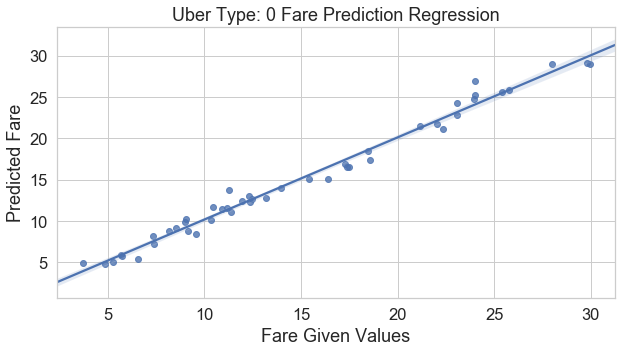

In [48]:
# MODEL FOR UBER TYPE: 0 ----------------------------------------------- 
x = model_data_ut0.iloc[:,:-1] #creating x variable for training
y = model_data_ut0['Fare$'] #creating y variable for training

#import random

# for i in range(0,100):
# a = random.randint(0,102)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 5)
    
lm_ut0 = LinearRegression()
reg = lm_ut0.fit(x_train,y_train)
predictions = lm_ut0.predict(x_test)

plt.subplots(figsize=(10,5))
f.subplots_adjust(wspace=0.4, hspace=0.4)

# plt.scatter(y_test,predictions,color="red")
a = sb.regplot(x=y_test, y=predictions)

a.set_title("Uber Type: 0 Fare Prediction Regression")
a.set_xlabel("Fare Given Values")
a.set_ylabel("Predicted Fare")
b.set_xlabel("Residual")
b.set_ylabel("Given Fare")

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))  
print('R Square:', metrics.r2_score(y_test, predictions))


Mean Absolute Error: 1.0478266848550952
Mean Squared Error: 1.9947125811336175
Root Mean Squared Error: 1.4123429403419048
R Square: 0.9894120925916262


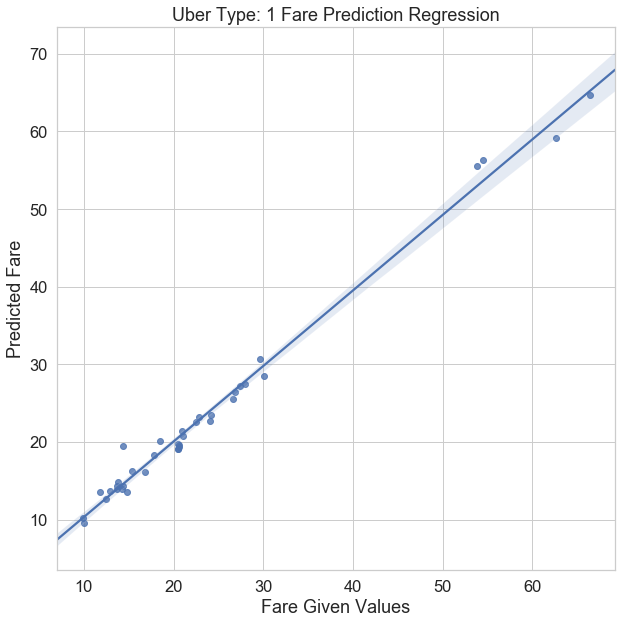

In [49]:
# MODEL FOR UBER TYPE: 1 ----------------------------------------------- 
x = model_data_ut1.iloc[:,:-1] #creating x variable for training
y = model_data_ut1['Fare$'] #creating y variable for training


# import random

# for i in range(0,100):
# a = random.randint(0,102)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 23)
    
lm_ut1 = LinearRegression()
reg = lm_ut1.fit(x_train,y_train)
predictions = lm_ut1.predict(x_test)

plt.subplots(figsize=(10,10))

# plt.scatter(y_test,predictions,color="red")
a = sb.regplot(x=y_test, y=predictions)

a.set_title("Uber Type: 1 Fare Prediction Regression")
a.set_xlabel("Fare Given Values")
a.set_ylabel("Predicted Fare")
b.set_xlabel("Predicted Fare")
b.set_ylabel("Given Fare")

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))  
print('R Square:', metrics.r2_score(y_test, predictions))
#print("------------------" + str(a) + "--------------------")


Mean Absolute Error: 27.410901166249502
Mean Squared Error: 1476.8268613421596
Root Mean Squared Error: 38.42950508843641
R Square: 0.9806146378732044


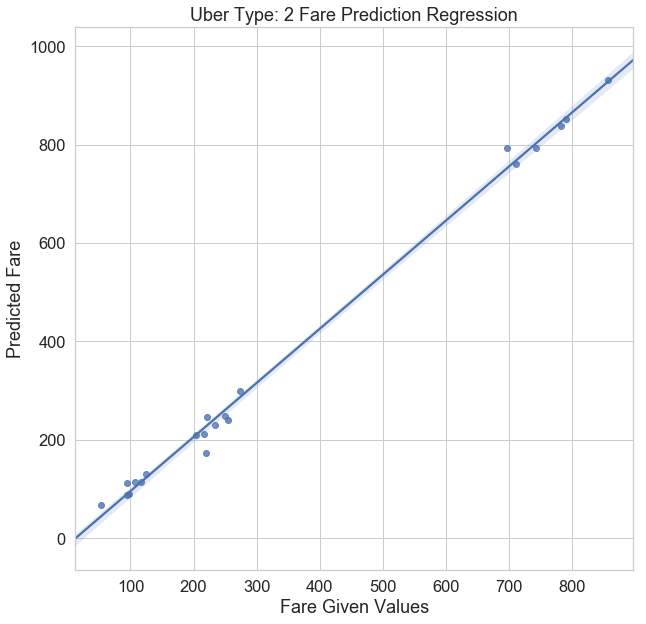

In [50]:
# MODEL FOR UBER TYPE: 2 ----------------------------------------------- 
x = model_data_ut2.iloc[:,:-1] #creating x variable for training
y = model_data_ut2['Fare$'] #creating y variable for training

#import random

#for i in range(0,100):
#a = random.randint(0,102)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state = 1)
    
lm_ut2 = LinearRegression()
reg = lm_ut2.fit(x_train,y_train)
predictions = lm_ut2.predict(x_test)

plt.subplots(figsize=(10,10))
# plt.scatter(y_test,predictions,color="red")
sb.regplot(x=y_test, y=predictions)

plt.title("Uber Type: 2 Fare Prediction Regression")
plt.xlabel("Fare Given Values")
plt.ylabel("Predicted Fare")

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))  
print('R Square:', metrics.r2_score(y_test, predictions))
#print("------------------" + str(a) + "--------------------")


#### 4.2.3 Predicting & Imputing for missing 'Fare$' values using the models build:

In [51]:
miss_ut0 = miss_df.loc[(miss_df['Uber Type'] == 0) & (miss_df['Fare$'].isna()),:]

x = miss_ut0.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]

predictions = lm_ut0.predict(x)

miss_ut0.loc[:,'Fare$'] = predictions
miss_ut0.reset_index(inplace=True)

for i in range(0,len(miss_ut0)):
    miss_df.loc[miss_df["Unnamed: 0"] == miss_ut0.iloc[i]["Unnamed: 0"],"Fare$"] = miss_ut0.loc[i,"Fare$"]


In [52]:
miss_ut1 = miss_df.loc[(miss_df['Uber Type'] == 1) & (miss_df['Fare$'].isna()),:]

x = miss_ut1.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]

predictions = lm_ut1.predict(x)

miss_ut1.loc[:,'Fare$'] = predictions
miss_ut1.reset_index(inplace=True)

for i in range(0,len(miss_ut1)):
    miss_df.loc[miss_df["Unnamed: 0"] == miss_ut1.iloc[i]["Unnamed: 0"],"Fare$"] = miss_ut1.loc[i,"Fare$"]

In [53]:
miss_ut2 = miss_df.loc[(miss_df['Uber Type'] == 2) & (miss_df['Fare$'].isna()),:]

x = miss_ut2.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]

predictions = lm_ut2.predict(x)

miss_ut2.loc[:,'Fare$'] = predictions
miss_ut2.reset_index(inplace=True)

for i in range(0,len(miss_ut2)):
    miss_df.loc[miss_df["Unnamed: 0"] == miss_ut2.loc[i, "Unnamed: 0"],["Fare$"]] = miss_ut2.loc[i,"Fare$"]

## Step 5:  Finding Outliers (if any)

In [54]:
outlier_df.head(5)

,Unnamed: 0,Unnamed: 0.1,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Departure Date,Departure Time,Travel Time(s),Arrival Time,Fare$
0,0,ID1717434181,0,3,1,-37.818138,144.969210,-37.801461,144.958161,2688.0,2018-02-22,08:04:10,668.40,8:15:18,5.44
1,1,ID1773039045,0,1,2,-37.813124,144.940103,-37.818970,144.946595,1085.0,2018-01-02,23:21:27,268.56,23:25:55,10.92
2,2,ID1239989104,0,6,9,-37.787433,144.980377,-38.110916,144.654173,47033.0,2018-06-10,05:35:50,11350.50,8:45:00,34.64
3,3,ID5826371523,2,1,8,-37.817975,144.951207,-37.815834,145.046450,8909.0,2018-02-14,07:33:23,2464.98,8:14:27,160.91
4,4,ID1551372482,0,6,1,-37.790797,144.985865,-37.814852,144.945010,5321.0,2018-02-16,17:39:40,1505.82,18:04:45,9.47


In [55]:
outlier_df.describe()

,Unnamed: 0,Uber Type,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance(m),Travel Time(s),Fare$
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,54.500000,0.609091,5.400000,4.990909,-37.857197,144.922784,-37.854792,144.927376,18316.890909,4699.745455,55.364273
std,31.898276,0.691965,2.552926,2.600266,0.110472,0.121296,0.100414,0.111762,18094.827817,4343.303921,138.250853
min,0.000000,0.000000,1.000000,1.000000,-38.110916,144.654173,-38.110916,144.654173,1085.000000,268.560000,2.490000
25%,27.250000,0.000000,3.250000,3.000000,-37.822244,144.927584,-37.861835,144.905716,5535.750000,1415.280000,10.335000
50%,54.500000,0.000000,5.000000,5.000000,-37.813130,144.952488,-37.815834,144.951796,8691.500000,2451.600000,16.355000
75%,81.750000,1.000000,8.000000,7.000000,-37.803085,144.990006,-37.806549,144.991124,42923.500000,10325.190000,31.287500
max,109.000000,2.000000,9.000000,9.000000,-37.773803,145.046450,-37.773803,145.046450,51061.000000,13204.980000,796.910000


In [56]:
# adding day factors and time factors based on Departure date and time
day_classifier(outlier_df)
time_classifier(outlier_df)

#### For Uber Type 0 (finding outliers):

Residual Mean: 0.8915010182565926
Residual std: 0.7530309137853527


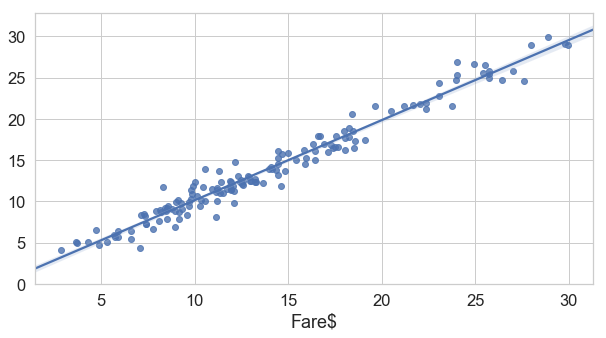

In [57]:
import statistics
x = model_data_ut0.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]
y = model_data_ut0["Fare$"]

# predicting fare for the whole dirty data (cleansed) + missing data (with non imputed values)
predictions = lm_ut0.predict(x)
model_data_ut0["predicted Fare$"] = predictions

# plotting the given fare vs. predicted fare
plt.subplots(figsize=(10,5))
sb.regplot(model_data_ut0["Fare$"],predictions)

# calculating the residual between the actual value and fitted value
model_data_ut0["Residual"] = abs(model_data_ut0["Fare$"] - model_data_ut0["predicted Fare$"])

# calculating mean and std for residual
mean0 = statistics.mean(model_data_ut0["Residual"])
std0 = statistics.pstdev(model_data_ut0["Residual"])

print("Residual Mean: "+ str(mean0))
print("Residual std: "+ str(std0))

34.64 30.311952983494404 4.328047016505597
15.81 26.87649787789685 11.066497877896849
7.225 11.768156788516631 4.543156788516631
32.49 27.4616572263414 5.028342773658601
10.94 18.41986676740406 7.47986676740406
25.34 21.668131488204235 3.671868511795765
30.9 26.08165681827889 4.818343181721108
22.89 18.6112127187979 4.278787281202099
9.805 15.260892912758964 5.455892912758964
12.66 7.741652120994496 4.918347879005504
17.045 27.88752860327454 10.842528603274538
8.14 14.858365618388962 6.718365618388962
13.06 20.075021282767832 7.015021282767831
9.025 16.543976917832115 7.518976917832115
33.61 27.65967106670565 5.950328933294351
34.52 28.922483480235663 5.597516519764341
31.01 25.287472329230777 5.7225276707692245
14.265 23.345175911779265 9.080175911779264
27.96 23.187555685987263 4.772444314012738
30.33 26.389444669385867 3.9405553306141314
29.62 23.03053430937956 6.58946569062044
34.39 29.378429186260494 5.011570813739507
15.18 11.483351661628236 3.696648338371764
26.01 21.72727851872

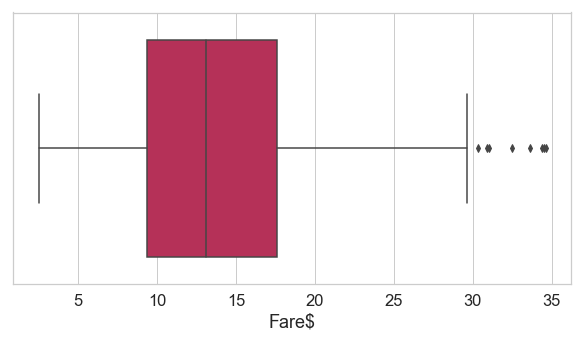

In [58]:
# taking outlier data for uber type 0
out_ut0 = outlier_df.loc[outlier_df['Uber Type'] == 0,:]
x = out_ut0.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]
y = out_ut0["Fare$"]

# predicting fare for the outlier dataset using our model
predictions = lm_ut0.predict(x)
out_ut0['predicted Fare$'] = predictions
#out_ut0.reset_index(inplace=True)

# plotting the given fare vs. predicted fare
plt.subplots(figsize=(10,5))
#sb.regplot(out_ut0["Fare$"],out_ut0['predicted Fare$'])
sb.boxplot('Fare$', data=out_ut0, palette="rocket")

# calculating the residual between the actual value and fitted value
out_ut0["Residual"] = abs(out_ut0["Fare$"] - out_ut0["predicted Fare$"])

# finding & dropping the outliers based on 3 sigma rejection rule (each residual is subtracted from mean and is compared with 3 sigma)
for i in out_ut0.index:
    if abs(out_ut0.loc[i]["Residual"] - mean0) > (3*std0):
        print(out_ut0.loc[i]["Fare$"], out_ut0.loc[i]['predicted Fare$'],  out_ut0.loc[i]["Residual"])
        out_ut0.drop(i, 0, inplace=True)
        outlier_df.drop(i, 0, inplace=True)
               

#### For Uber Type 1 (finding outliers):

Residual Mean: 0.9683723817220853
Residual std: 0.8551542406195689


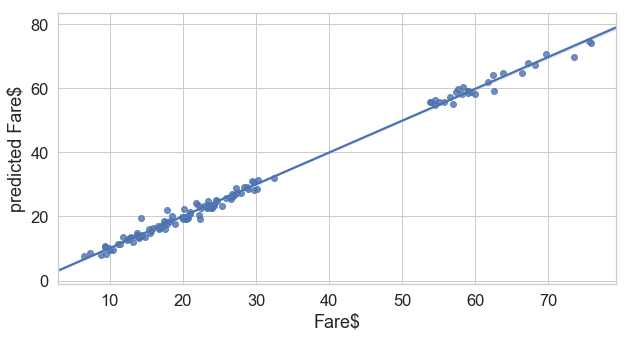

In [59]:
x = model_data_ut1.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]
y = model_data_ut1["Fare$"]

predictions = lm_ut1.predict(x)

model_data_ut1["predicted Fare$"] = predictions
model_data_ut1["Residual"] = abs(model_data_ut1["Fare$"] - model_data_ut1["predicted Fare$"])
model_data_ut1.head(5)

# plotting the given fare vs. predicted fare
plt.subplots(figsize=(10,5))
sb.regplot(model_data_ut1["Fare$"],model_data_ut1["predicted Fare$"])

# calculating mean and std for residual
mean1 = statistics.mean(model_data_ut1["Residual"])
std1 = statistics.pstdev(model_data_ut1["Residual"])

print("Residual Mean: "+ str(mean1))
print("Residual std: "+ str(std1))

24.71 59.941615621359816 35.231615621359815
49.88 60.46176072988695 10.581760729886945
29.69 34.544428177058194 4.8544281770581925
31.38 35.35343829673971 3.9734382967397117
54.95 67.1840899082007 12.234089908200701
53.81 62.061939841446744 8.251939841446742
43.97 54.052970925890094 10.082970925890095
9.4 20.725492795302436 11.325492795302436
52.46 62.699743001436346 10.239743001436345
6.965 16.92427380127309 9.959273801273088
58.89 68.01466076429216 9.124660764292159
11.355 25.54959529940397 14.194595299403968
26.95 31.49292312396113 4.542923123961131
46.44 56.59000726351887 10.150007263518873
58.72 71.55622822736086 12.836228227360863
49.13 59.49888606901527 10.368886069015268
21.93 25.8220394673005 3.892039467300499
8.49 20.564830542098537 12.074830542098537
8.795 20.44568222779455 11.65068222779455


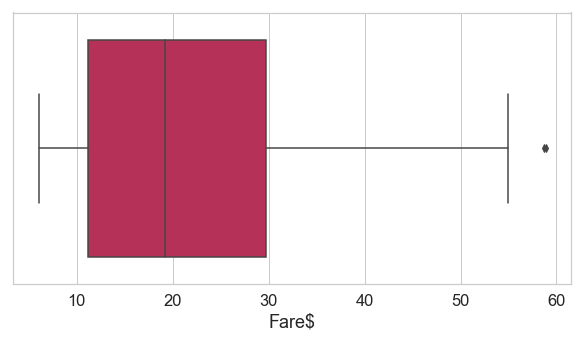

In [60]:
out_ut1 = outlier_df.loc[outlier_df['Uber Type'] == 1,:]

x = out_ut1.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]
y = out_ut1["Fare$"]

predictions = lm_ut1.predict(x)

out_ut1['predicted Fare$'] = predictions
#out_ut1.reset_index(inplace=True)

out_ut1["Residual"] = abs(out_ut1["Fare$"] - out_ut1["predicted Fare$"])

# plotting the given fare vs. predicted fare
plt.subplots(figsize=(10,5))
#sb.regplot(out_ut1["Fare$"],out_ut1["predicted Fare$"])
sb.boxplot('Fare$', data=out_ut1, palette="rocket")

for i in out_ut1.index:
    if abs(out_ut1.loc[i]["Residual"] - mean1) > (3*std1):
        print(out_ut1.loc[i]["Fare$"], out_ut1.loc[i]['predicted Fare$'],  out_ut1.loc[i]["Residual"])
        out_ut1.drop(i, 0, inplace=True)
        outlier_df.drop(i, 0, inplace=True)
        

#### For Uber Type 2 (finding outliers):

Residual Mean: 31.415780245421207
Residual std: 39.033182295629295


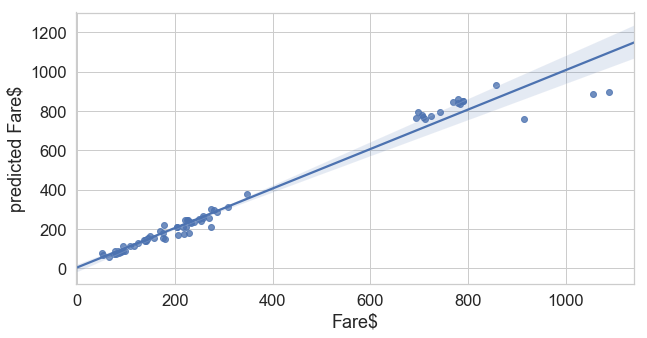

In [61]:
x = model_data_ut2.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]
y = model_data_ut2["Fare$"]

predictions = lm_ut2.predict(x)

model_data_ut2["predicted Fare$"] = predictions
model_data_ut2["Residual"] = abs(model_data_ut2["Fare$"] - model_data_ut2["predicted Fare$"])
model_data_ut2.head(5)

# plotting the given fare vs. predicted fare
plt.subplots(figsize=(10,5))
sb.regplot(model_data_ut2["Fare$"],model_data_ut2["predicted Fare$"])

mean2 = statistics.mean(model_data_ut2["Residual"])
std2 = statistics.pstdev(model_data_ut2["Residual"])

print("Residual Mean: "+ str(mean2))
print("Residual std: "+ str(std2))

724.47 888.8372694460911 164.3672694460911


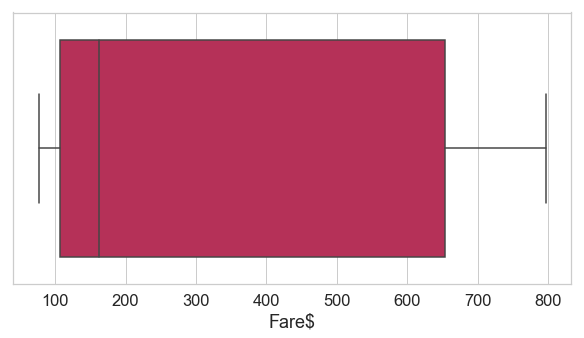

In [62]:
out_ut2 = outlier_df.loc[outlier_df['Uber Type'] == 2,:]

x = out_ut2.loc[:,['Journey Distance(m)', 'Travel Time(s)', 'day_factor', 'time_factor']]
y = out_ut2["Fare$"]

predictions = lm_ut2.predict(x)

out_ut2['predicted Fare$'] = predictions
out_ut2["Residual"] = abs(out_ut2["Fare$"] - out_ut2["predicted Fare$"])

plt.subplots(figsize=(10,5))
sb.boxplot('Fare$', data=out_ut2, palette="rocket")

for i in out_ut2.index:
    if abs(out_ut2.loc[i]["Residual"] - mean2) > (3*std2):
        print(out_ut2.loc[i]["Fare$"], out_ut2.loc[i]['predicted Fare$'],  out_ut2.loc[i]["Residual"])
        out_ut2.drop(i, 0, inplace=True)
        outlier_df.drop(i, 0, inplace=True)


### Step 6: Generating final output files

<ul>
    <li>29857082_dirty_data_solution.csv</li>
    <li>29857082_missing_value_solution.csv</li>
    <li>29857082_outliers_solution.csv</li>
</ul>    

#### 6.1 Changing the dtypes back to original dtypes

In [63]:
dirty_df["Arrival Time"] = dirty_df["Arrival Time"].astype("str")
dirty_df["Departure Time"] = dirty_df["Departure Time"].astype("str")

#### 6.2 Deleting additional column added in the datasets

In [64]:
del dirty_df["day_factor"]
del dirty_df["time_factor"]
del dirty_df["corrected"]

In [65]:
del miss_df["day_factor"]
del miss_df["time_factor"]

del outlier_df["day_factor"]
del outlier_df["time_factor"]

#### 6.3 Generating the solution files for dirty_data, missing_values and outliers

In [67]:
dirty_df.to_csv("dirty_data_solution.csv", sep=',')
miss_df.to_csv("missing_value_solution.csv", sep=',')
outlier_df.to_csv("outliers_solution.csv", sep=',')

### Step 7: Summary

After doing the EDA we found certain errros and inconsistencies the dirty data which we fixed (Approx. in 77 records). The errors which we figured out are as follows:
1. Invalid origin latitude
2. Invalid destination latitude
3. Departure Date (month and date swapped)
4. Departure Date (exceeding the dates of month)
5. Additional Uber Type
6. Uber Type 1, 2 (some ids not following the pattern) 
7. Wrong region allocated
8. Wrong journey distance
9. Wrong travel time
10. Wrong arrival time

Then we tried to impute the missing values for Uber Type and Fare$ based on the linear model we generated as Fare depends on 4 other dimensions like (Journey distance, Travel time, Day Factor, Time Factor).

Then we tried to detect the outliers based on different types of Uber based on 3 sigma rejection rule and removed the outliers.